[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/main.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Анализ датасета BelgiumTSC
https://www.kaggle.com/datasets/mahadevkonar/belgiumts-dataset

Датасет содержит каталоги:
- BelgiumTSC_Training/Training;
- BelgiumTSC_Testing/Testing.  
Каждый из каталогов содержит каталоги с именами 00000 - 00061 с изображениями соответствующих классов

In [164]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone

if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'


In [2]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import matplotlib.patches as patches

#from pycocotools.coco import COCO
#import fiftyone as fo
import time
import torch
import torch.nn as nn
#import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet152
from sklearn import metrics
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN

#import cv2

### Train

In [204]:
BelgiumTSC_train = pd.DataFrame()
list_directory = os.listdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training'))
for directory in list_directory:
    if os.path.isdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training', directory)) == True:
        df_temp = pd.read_csv(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training', directory, f"GT-{directory}.csv"), sep = ';')
        for i in range(len(df_temp)):
            df_temp.loc[i, 'Filename'] = f'BelgiumTSC_Training/Training/{directory}/' + df_temp.loc[i, 'Filename']
        BelgiumTSC_train = pd.concat((BelgiumTSC_train, df_temp))
BelgiumTSC_train.reset_index(inplace=True)
del BelgiumTSC_train['index']
BelgiumTSC_train

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,BelgiumTSC_Training/Training/00000/01153_00000...,141,142,12,12,128,130,0
1,BelgiumTSC_Training/Training/00000/01153_00001...,120,123,10,10,109,113,0
2,BelgiumTSC_Training/Training/00000/01153_00002...,105,107,9,9,96,98,0
3,BelgiumTSC_Training/Training/00000/01160_00000...,94,105,8,9,86,95,0
4,BelgiumTSC_Training/Training/00000/01160_00001...,128,139,11,12,117,127,0
...,...,...,...,...,...,...,...,...
4586,BelgiumTSC_Training/Training/00061/01957_00001...,75,74,6,6,69,67,61
4587,BelgiumTSC_Training/Training/00061/01957_00002...,55,53,5,5,49,48,61
4588,BelgiumTSC_Training/Training/00061/01959_00000...,111,67,9,6,102,61,61
4589,BelgiumTSC_Training/Training/00061/01959_00001...,39,39,5,5,34,34,61


Сопоставим классы

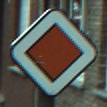

In [427]:
class_id = 61
index = 1
df_temp = BelgiumTSC_train[BelgiumTSC_train['ClassId'] == class_id].copy()
df_temp.reset_index(inplace=True)
img_name = df_temp.loc[index, 'Filename']
Image.open(os.path.join(dataset_path, 'BelgiumTSC', img_name))

Расшифровка знаков
- 0 - Ухабистая дорога                            1_16
- 1 - Отбойник (лежачий полицейский)              1_17
- 2 - Скользкая дорога                            1_15
- 3 - Опасный поворот (налево)                    1_11_1
- 4 - Опасный поворот (направо)                   1_11       
- 5 - Опасные повороты (первый налево)            1_12_2
- 6 - Опасные повороты (первый направо)           1_12
- 7 - Школьная зона (немного не похоже)           1_23
- 8 - Велосипеды могут пересекать (в RTSD нет)
- 9 - Пересечение домашних животных               1_26
- 10 - Ремонтные работы                           1_25
- 11 - Светофор                                   1_8
- 12 - Закрытый железнодорожный переезд впереди   1_1
- 13 - Осторожно                                  1_33
- 14 - Дорога сужается                            1_20
- 15 - Дорога сужается слева                      1_20_3
- 16 - Дорога сужается справа                     1_20_2
- 17 - пересечение с второстепенной  дорогой (в RTSD разбито на категории)
- 18 - перекресток с приоритетом направо          1_6
- 19 - Уступить дорогу                            2_4
- 20 - Преимущество встречного движения           2_6
- 21 - Остановитесь и уступите дорогу             2_5
- 22 - Запрещенное направление для всех водителей 3_1
- 23 - водителям велосипедов въезд запрещен       
- 24 - Ограничение по массе                       3_11
- 25 - Грузовым въезд запрещен                    3_4
- 26 - Ограничение по ширине                      3_14
- 27 - Ограничение по высоте                      3_13
- 28 - Въезд запрещен (движение)                  3_2
- 29 - Поворот налево запрещен                    3_18_2
- 30 - Поворот направо запрещен                   3_18
- 31 - запрещен обгон транспортных средств        3_20
- 32 - Ограничение скорости                       3_24
- 33 - Велопешеходная дорожка с совмещенным движением
- 34 - Движение прямо                             4_1_1
- 35 - Движение абы куда (стрелка)          
- 36 - Движение прямо и направо                   4_1_4
- 37 - Круговое движение                          4_3
- 38 - Обязательная велосипедная дорожка          
- 39 - Велопешеходная дорожка с разделением движения
- 40 - Парковка запрещена                         3_28
- 41 - Парковка и остановка запрещены             3_27
- 42 - Парковка запрещена с 1 по 15 число месяца  3_27
- 43 - Парковка запрещена с 15-го                 3_27
- 44 - Преимущество перед встречным движением     2_7
- 45 - Парковка разрешена                         6_4
- 46 - Парковка, предназначенная для инвалидов    6_4
- 47 - парковка, предназначенная для ...          6_4
- 48 - Парковка, предназначенная для грузовиков   6_4
- 49 - Парковка, предназначенная для автобусов    6_4
- 50 - парковка на обочине или тротуаре           6_4
- 51 - Начало живой улицы                         5_21            
- 52 - Конец оживленной улицы                     5_22
- 53 - дорога с односторонним движением           5_5
- 54 - Тупик                                      6_8_1
- 55 - Окончание дорожных работ
- 56 - Пешеходный переход (немного не похож)      5_19_1
- 57 - пересечение велосипедиста и мопеда
- 58 - Автостоянка                                
- 59 - Горб                                       5_20
- 60 - Конец приоритетной дороги                  2_2
- 61 - Приоритетная дорога                        2_1

Распределение частот появления классов в обучающей выборке

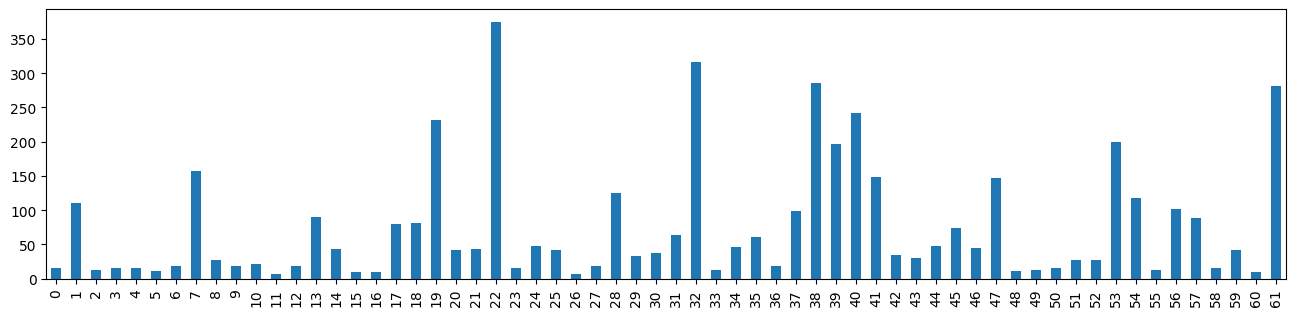

In [429]:
Train_counts = pd.Series(data = BelgiumTSC_train.value_counts(['ClassId']).sort_index())
Train_counts.index = range(62)
fig, ax = plt.subplots(nrows=1,ncols=1)
ax = Train_counts.plot(kind='bar')
fig.set_size_inches(16,3.5)
plt.show()

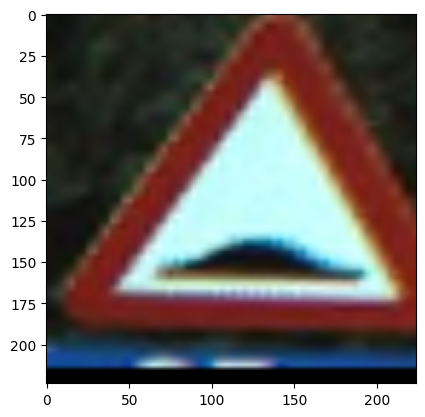

In [449]:
image_id = 116
x1 = BelgiumTSC_train.loc[image_id, 'Roi.X1']
y1 = BelgiumTSC_train.loc[image_id, 'Roi.Y1']
x2 = BelgiumTSC_train.loc[image_id, 'Roi.X2']
y2 = BelgiumTSC_train.loc[image_id, 'Roi.Y2']
bbox = [x1, y1, x2, y2]
img = Image.open(os.path.join(dataset_path, 'BelgiumTSC', BelgiumTSC_train.loc[image_id, 'Filename'])).crop(bbox)
transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor()
                                    ])   
img = transform(img)
img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
fig, a = plt.subplots(1,1)
a.imshow(img)

Сохраним датафрейм в 1 файл

In [483]:
BelgiumTSC_train.to_csv(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_train.csv'))

### Test

In [457]:
BelgiumTSC_test = pd.DataFrame()
list_directory = os.listdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing'))
for directory in list_directory:
    if os.path.isdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing', directory)) == True:
        df_temp = pd.read_csv(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing', directory, f"GT-{directory}.csv"), sep = ';')
        for i in range(len(df_temp)):
            df_temp.loc[i, 'Filename'] = f'BelgiumTSC_Testing/Testing/{directory}/' + df_temp.loc[i, 'Filename']
        BelgiumTSC_test = pd.concat((BelgiumTSC_test, df_temp))
BelgiumTSC_test.reset_index(inplace=True)
del BelgiumTSC_test['index']
BelgiumTSC_test

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,BelgiumTSC_Testing/Testing/00000/00017_00000.ppm,107,108,9,9,98,99,0
1,BelgiumTSC_Testing/Testing/00000/00017_00001.ppm,94,98,8,8,86,89,0
2,BelgiumTSC_Testing/Testing/00000/00017_00002.ppm,100,106,8,9,91,96,0
3,BelgiumTSC_Testing/Testing/00000/00021_00000.ppm,57,61,5,5,51,55,0
4,BelgiumTSC_Testing/Testing/00000/00021_00001.ppm,59,62,5,5,53,56,0
...,...,...,...,...,...,...,...,...
2529,BelgiumTSC_Testing/Testing/00061/00713_00001.ppm,107,96,9,8,97,88,61
2530,BelgiumTSC_Testing/Testing/00061/00713_00002.ppm,179,85,15,7,164,78,61
2531,BelgiumTSC_Testing/Testing/00061/00718_00000.ppm,67,70,6,6,61,63,61
2532,BelgiumTSC_Testing/Testing/00061/00718_00001.ppm,57,58,5,5,51,53,61


Распределение частот появления классов в тестовой выборке

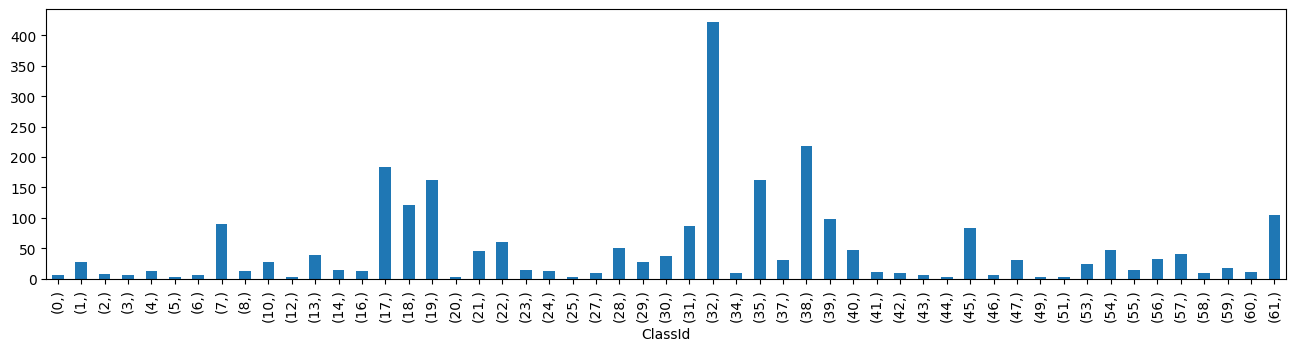

In [478]:
# Увеличим расстояние между графиками
Test_counts = pd.Series(data = BelgiumTSC_test.value_counts(['ClassId']).sort_index())
#Test_counts.index = range(62)
fig, ax = plt.subplots(nrows=1,ncols=1)
ax = Test_counts.plot(kind='bar')
fig.set_size_inches(16,3.5)
plt.show()

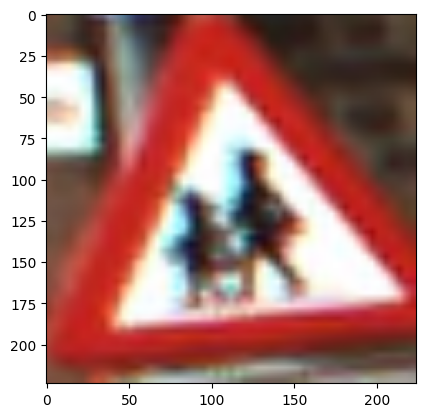

In [481]:
image_id = 122
x1 = BelgiumTSC_test.loc[image_id, 'Roi.X1']
y1 = BelgiumTSC_test.loc[image_id, 'Roi.Y1']
x2 = BelgiumTSC_test.loc[image_id, 'Roi.X2']
y2 = BelgiumTSC_test.loc[image_id, 'Roi.Y2']
bbox = [x1, y1, x2, y2]
img = Image.open(os.path.join(dataset_path, 'BelgiumTSC', BelgiumTSC_test.loc[image_id, 'Filename'])).crop(bbox)
transform = A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              ToTensorV2(p=1.0)
                            ])
img = np.array(img).astype(np.float32)/255.
img = transform(image=img)['image']

img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
fig, a = plt.subplots(1,1)
a.imshow(img)

Сохраним датафрейм в 1 файл

In [484]:
BelgiumTSC_test.to_csv(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_test.csv'))

### Обучение классификатора на датасете BelgiumTSC (без аугментации)

Загрузчик данных

In [489]:
class GTSRB_dataset_classifier(Dataset):
    def __init__(self, dataset_path, anno, transforms, crop = False):
        
        self.dataset_path = dataset_path
        self.transforms = transforms
        self.df_dataset = pd.read_csv(os.path.join(dataset_path, 'BelgiumTSC', anno))
        self.crop = crop

    def __len__(self):
        return self.df_dataset.shape[0]

    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'Filename']
        img = Image.open(os.path.join(self.dataset_path, 'BelgiumTSC', img_name))

        if self.crop == True:
            x1 = self.df_dataset.loc[index, 'Roi.X1']
            y1 = self.df_dataset.loc[index, 'Roi.Y1']
            x2 = self.df_dataset.loc[index, 'Roi.X2']
            y2 = self.df_dataset.loc[index, 'Roi.Y2']
            bbox = [x1, y1, x2, y2]
            img = img.crop(bbox)
        img = self.transforms(img)

        label = torch.tensor(self.df_dataset.loc[index,'ClassId'])
        
        return {'images':img, 'labels':label}

def get_transform(): 
    return transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               ])   

In [511]:
test = GTSRB_dataset_classifier(dataset_path,
                                anno = 'BelgiumTSC_train.csv',
                                transforms = get_transform(),
                                crop = True)
test.__getitem__(2)['images'].shape

torch.Size([3, 224, 224])

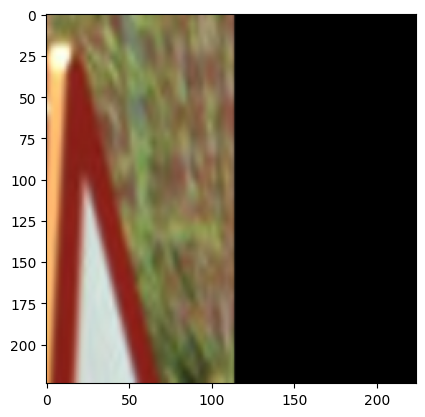

In [513]:
image_id = 121
img = test.__getitem__(image_id)['images']
img = img.permute(1, 2, 0).detach().numpy()
img = img*255
img = img.astype(np.uint8)
fig, a = plt.subplots(1,1)
a.imshow(img)

Гиперпараметры

In [514]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'

model_name = 'BelgiumTSC_resnet152_adam_001'
last_epoch = None
n_epochs = 5
batch_size = 32
num_classes = 62

device

'cuda:0'

Инициализация модели, задание оптимизатора и функции потерь

In [515]:
def create_model(num_classes):
    model = resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
    for param in model.parameters():
        param.requires_grad = False 
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

In [517]:
model = create_model(num_classes).to(device)

loss_function = nn.CrossEntropyLoss()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

train_dataset = GTSRB_dataset_classifier(dataset_path,
                                         anno = 'BelgiumTSC_train.csv',
                                         transforms = get_transform(),
                                         crop = False)

val_dataset = GTSRB_dataset_classifier(dataset_path,
                                       anno = 'BelgiumTSC_test.csv',
                                       transforms = get_transform(),
                                       crop = False)

train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               )

val_data_loader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             shuffle=False
                             )

In [518]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)

    training_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.train()
    running_loss = 0        # training_loss
    
    for batch_idx, data in enumerate(train_dataloader):
        
        optimizer.zero_grad()
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        output = model(images)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()
       
        running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%20 == 0:
            print(f"Batch Id {batch_idx} is having training loss of {running_loss}")
            print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader} on Training is {(100*correct/total)}")
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

    train_loss = running_loss/len(train_dataloader.dataset)
    train_accuracy = metrics.accuracy_score(y_true, y_pred)
    train_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    train_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    train_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")
    return train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted

In [519]:
def val (val_dataloader, epoch):
    len_dataloader = len(val_dataloader)

    validation_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.eval()

    for batch_idx, data in enumerate(val_dataloader):
        
        
        optimizer.zero_grad()
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        #with torch.no_grad():
            
        output = model(images)
        loss = loss_function(output, targets)
        
        validation_loss = validation_loss + ((1/(batch_idx+1))*(loss.data-validation_loss))
        #if batch_idx%20 == 0:
        print(f"Epoch #{epoch}. Batch Id {batch_idx} is having validation loss of {validation_loss}")
        print(loss.item())
        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader} is having validation accuracy of {(100*correct/total)}")

        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

    val_loss = validation_loss/len(val_dataloader.dataset)
    val_accuracy = metrics.accuracy_score(y_true, y_pred)
    val_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    val_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    val_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")


    return val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted

In [520]:
# Загрузка словарей с лоссами
if last_epoch is not None:
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']
    train_accuracies = checkpoint['accuracies_train']
    val_accuracies = checkpoint['accuracies_val']
    train_f1_micros = checkpoint['train_f1_micro']
    val_f1_micros = checkpoint['val_f1_micro']
    train_f1_macros = checkpoint['train_f1_macro']
    val_f1_macros = checkpoint['val_f1_macro']
    train_f1_weighteds = checkpoint['train_f1_weighted']
    val_f1_weighteds = checkpoint['val_f1_weighted']
else:
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_micros = []
    val_f1_micros = []
    train_f1_macros = []
    val_f1_macros = []
    train_f1_weighteds = []
    val_f1_weighteds = []

if last_epoch is None:
    start_epoch = 0
else:
    start_epoch = last_epoch +1

try:
    for epoch in range(start_epoch, n_epochs):
        start = time.time()
        train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted = train(train_data_loader, epoch)
        val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_f1_micros.append(train_f1_micro)
        val_f1_micros.append(val_f1_micro)
        train_f1_macros.append(train_f1_macro)
        val_f1_macros.append(val_f1_macro)
        train_f1_weighteds.append(train_f1_weighted)
        val_f1_weighteds.append(val_f1_weighted)
        

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    #'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    'losses_val': val_losses,
                    'accuracies_train': train_accuracies,
                    'accuracies_val': val_accuracies,
                    'f1_micros_train': train_f1_micros,
                    'f1_micros_val': val_f1_micros,
                    'f1_macros_train': train_f1_macros,
                    'f1_macros_val': val_f1_macros,
                    'f1_weighteds_train': train_f1_weighteds,
                    'f1_weighteds_val': val_f1_weighteds,
                    }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

Batch Id 0 is having training loss of 4.131896018981934
4.131896018981934
Epoch #0. Accuracy on batch 0/144 on Training is 0.0
Epoch #0. Accuracy on batch 1/144 on Training is 7.8125
Epoch #0. Accuracy on batch 2/144 on Training is 9.375
Epoch #0. Accuracy on batch 3/144 on Training is 9.375
Epoch #0. Accuracy on batch 4/144 on Training is 11.875
Epoch #0. Accuracy on batch 5/144 on Training is 11.458333333333334
Epoch #0. Accuracy on batch 6/144 on Training is 12.946428571428571
Epoch #0. Accuracy on batch 7/144 on Training is 14.0625
Epoch #0. Accuracy on batch 8/144 on Training is 15.972222222222221
Epoch #0. Accuracy on batch 9/144 on Training is 16.5625
Epoch #0. Accuracy on batch 10/144 on Training is 17.329545454545453
Epoch #0. Accuracy on batch 11/144 on Training is 18.229166666666668
Epoch #0. Accuracy on batch 12/144 on Training is 18.990384615384617
Epoch #0. Accuracy on batch 13/144 on Training is 20.3125
Epoch #0. Accuracy on batch 14/144 on Training is 21.041666666666668

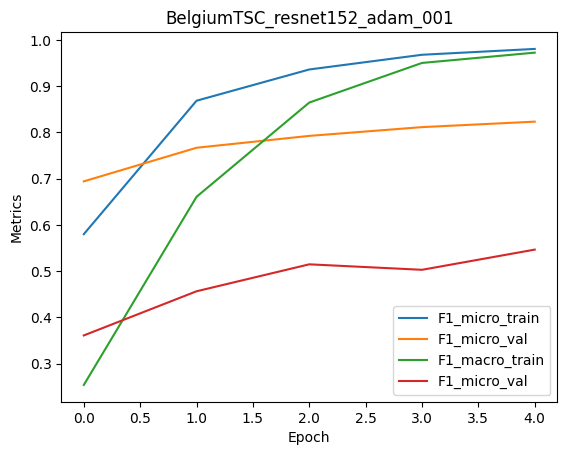

In [522]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_micro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
plt.show()